# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/ECE_661/661_Final_Project')

In [ ]:
# import necessary dependencies
import argparse
import os
import time
import tools
import datetime
from tqdm import tqdm_notebook as tqdm

from tools import opencv_functional as cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import itertools

In [ ]:
# define the ResBlock to be used in ResNet;
class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, k_size=3, stride_bool=False):
        super(ResBlock, self).__init__()
        if(stride_bool == True):
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, stride=2, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
        else:
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1)

        if input_dim != output_dim:
          input_dim = output_dim
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        y = x
      # Note shortcut will just be x if of same shape as out
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) 
        if (x.shape == out.shape):
          out = out + y
          out = F.relu(out)
          return out
        else:
          y = self.resconv(y)
          out = out.add(y)
          out = F.relu(out)
          return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    # 16 filter res blockss
    self.res1 = ResBlock(16, 16)
    self.res2 = ResBlock(16, 16)
    self.res3 = ResBlock(16, 16)
    # Now 32 filter res blocks
    self.res4 = ResBlock(16, 32, stride_bool=True)
    self.res5 = ResBlock(32, 32)
    self.res6 = ResBlock(32, 32)
    # Now 64 filter res blocks 
    self.res7 = ResBlock(32, 64, stride_bool=True)
    self.res8 = ResBlock(64, 64)
    self.res9 = ResBlock(64, 64)

    self.fc = nn.Linear(64, 10)
    self.fc2 = nn.Linear(64,4)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))

    # ReLU contained within forward method of res blocks
    
    out = self.res1(out)
    out = self.res2(out)
    out = self.res3(out)

    out = self.res4(out)
    out = self.res5(out)
    out = self.res6(out)

    out = self.res7(out)
    out = self.res8(out)
    out = self.res9(out)

    out = F.adaptive_avg_pool2d(out, 1)
    out = out.view(out.size(0), -1)
    outt = self.fc(out)
    outr = self.fc2(out)
    # out = F.softmax(out)
    return outt, outr

In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                                      transforms.RandomCrop(size=(32,32), padding=4),
                                      # transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(degrees=15)]) 
                                      # transforms.GaussianBlur(kernel_size=5, sigma = 0.5)])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
#############################################

In [ ]:
# do NOT change these
#import tools
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

#############################################

0it [00:00, ?it/s]

Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Implementing the data perturbation from the paper


In [ ]:
expanded_params = ((0, -56, 56), (0, -56, 56))

shift = np.cumsum([0] + [len(p) for p in expanded_params[:-1]]).tolist()
num_params = [len(expanded_params[i]) for i in range(len(expanded_params))]
n_p1, n_p2 = num_params[0], num_params[1]
output_dim = sum(num_params) + 4  # +4 due to four rotations

pert_configs = []
for tx, ty in itertools.product(*expanded_params):
    pert_configs.append((tx, ty))

num_perts = len(pert_configs)

# resize_and_crop = trn.Compose([trn.Resize(256), trn.RandomCrop(224)])

In [ ]:
class PerturbDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, train_mode=True):
        self.dataset = dataset
        self.train_mode = train_mode

    def __getitem__(self, index):
        x, y = self.dataset[index // num_perts]
        pert = pert_configs[index % num_perts]

        
        label = [y]
        label = np.vstack((label + [0], label + [1], label + [2], label + [3]))

        x = x.unsqueeze(0).numpy()
        x = np.concatenate((x, np.rot90(x, 1, axes=(2, 3)),
                            np.rot90(x, 2, axes=(2, 3)), np.rot90(x, 3, axes=(2, 3))), 0)

        return torch.FloatTensor(x), label

    def __len__(self):
        if self.train_mode:
            return 1300 * num_perts
        else:
            return 100 * num_perts

In [ ]:
train_data = PerturbDataset(train_set)

In [ ]:
import matplotlib.pyplot as plt

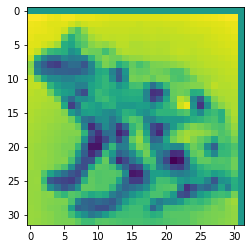

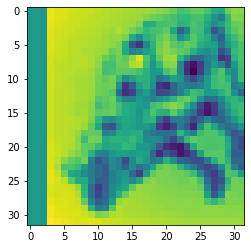

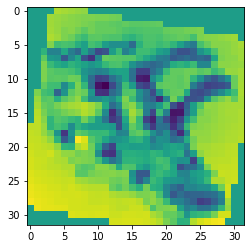

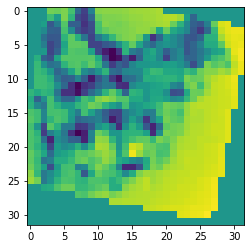

In [ ]:
plt.imshow(train_data.__getitem__(0)[0][0][0])
plt.figure()
plt.imshow(train_data.__getitem__(0)[0][1][0])
plt.figure()
plt.imshow(train_data.__getitem__(0)[0][2][0])
plt.figure()
plt.imshow(train_data.__getitem__(0)[0][3][0])

In [ ]:
print(train_data.__getitem__(0)[1][0][0])
print(train_data.__getitem__(0)[1][1])
print(train_data.__getitem__(0)[1][2])
print(train_data.__getitem__(0)[1][3])

1
[1 1]
[1 2]
[1 3]


In [ ]:
# construct dataloader
train_loader = DataLoader(
    train_data, 
    batch_size=256,  # your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=4
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
  

Run on GPU...


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

net = ResNet().to(device)
# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


## Only data augmentation


In [ ]:
# Just data augmentation
lam = 0
# some hyperparameters
# total number of training epochs
EPOCHS = 200
 
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

# Calculate initial loss 
initial_loss = 0
for batch_idx, (inputs, targets) in enumerate(train_loader):
  inputs = inputs.to(device)
  targets = targets.to(device)
  # print(targets.shape)
  # print(inputs.shape)

  # print(max(targets[:,0,0])) #this is the target for the label / classification
  # print(max(targets[:,0,1])) # this is the target for the rotation amount - i.e will be 0 for 0,1, one for 1,1 two for 2,1, three for 3,1
  output0 = net(inputs[:,0,:,:,:]) #this is output of unrotated image - change 0 to 1 for 90, 0 to 2 for 180, 0 to 3 for 270 
  # compute the output and loss
  # outputs = net(inputs[:,:3,:,:])[0]
  initial_loss = criterion(output0[0], targets[:,0,0]) #this should just be initial classification loss 
  # initial_loss += loss
print("Initial loss: %.4f" %(initial_loss))

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
#     # handle the learning rate scheduler.
  #  if i % DECAY_EPOCHS == 0 and i != 0:
#         current_learning_rate = current_learning_rate * DECAY
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = current_learning_rate
#         print("Current learning rate has decayed to %f" %current_learning_rate)
    if 140 > i > 100  :
      current_learning_rate = 0.1
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
      print("Current learning rate has decayed to %f" %current_learning_rate)
    if 170 > i > 140  :
      current_learning_rate = 0.001
      momentum = 0.6
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
          param_group['momentum'] = momentum
      print("Current learning rate has decayed to %f" %current_learning_rate)
    if i > 170  :
      current_learning_rate = 0.0005
      momentum = 0.3
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
          param_group['momentum'] = momentum
      print("Current learning rate has decayed to %f" %current_learning_rate)
    
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        # inputs = inputs.to(device)
        # targets = targets.to(device)
        # print(inputs.shape)
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        
        output0 = net(2 * inputs[:,0,:,:] - 1)
        output90 = net(2 * inputs[:,1,:,:] - 1)
        output180 = net(2 * inputs[:,2,:,:] - 1)
        output270 = net(2 * inputs[:,3,:,:] - 1)
       
        
        loss = criterion(output0[0], targets[:,0,0]) #loss from classification
        loss += lam * .25* criterion(output0[1], targets[:,0,1]) #now adding in weighted rotation loss for unrotated
        loss += lam * .25* criterion(output90[1], targets[:,1,1]) #again, weighted rotation loss for 90 degree
        loss += lam * .25* criterion(output180[1], targets[:,2,1]) #again, weighted rotation loss for 180 degree
        loss += lam * .25* criterion(output270[1], targets[:,3,1]) #again, weighted rotation loss for 270 degree
      
        # compute the output and loss

       
        train_loss += loss
        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        # _, predicted = torch.max(output0[0], 1)
        _, predicted = torch.max(output0[0], 1)
        # correct = predicted.eq(targets[:,0, 0]).sum()
        correct = predicted.eq(targets[:,0,0]).sum() #looking at correct labels

        total_examples += targets.shape[0]
        correct_examples += correct.item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = net(inputs)[0]
            val_loss += criterion(outputs, targets)
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            total_examples += targets.shape[0]
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet_base.pth'))
        # model.load_state_dict(state_dict["state_dict"])
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

Initial loss: 2.4113
==> Training starts!
Epoch 0:
Training loss: 2.0014, Training accuracy: 0.2553
Validation loss: 2.3104, Validation accuracy: 0.1608
Saving ...

Epoch 1:
Training loss: 1.6574, Training accuracy: 0.3779
Validation loss: 2.2543, Validation accuracy: 0.2408
Saving ...

Epoch 2:
Training loss: 1.4357, Training accuracy: 0.4702
Validation loss: 2.8870, Validation accuracy: 0.2002

Epoch 3:
Training loss: 1.2388, Training accuracy: 0.5419
Validation loss: 2.8117, Validation accuracy: 0.2466
Saving ...

Epoch 4:
Training loss: 1.0186, Training accuracy: 0.6275
Validation loss: 2.7771, Validation accuracy: 0.2746
Saving ...

Epoch 5:
Training loss: 0.8389, Training accuracy: 0.6985
Validation loss: 2.7680, Validation accuracy: 0.2706

Epoch 6:
Training loss: 0.6679, Training accuracy: 0.7567
Validation loss: 2.6591, Validation accuracy: 0.3050
Saving ...

Epoch 7:
Training loss: 0.5323, Training accuracy: 0.8074
Validation loss: 2.7842, Validation accuracy: 0.3066
Saving .